In [27]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple
from scipy.optimize import bisect, minimize_scalar

# **Одномерная оптимизация нулевого порядка**

Метод золотого сечения

In [28]:
def golden_ratio_method(
    f: Callable[[float], float], a: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    K = (np.sqrt(5) - 1) / 2
    x = b - (b - a) * K
    y = a + (b - a) * K

    fx, fy= f(x), f(y)

    for k in range(max_iter):
        if fx < fy:
            b = y
            y = x
            fy = fx
            x = b - (b - a) * K
            fx = f(x)
        else:
            a = x
            x = y
            fx = fy
            y = a + (b - a) * K
            fy = f(y)

        if (b - a) * K < epsilon:
            break

    return (x, fx) if fx < fy else (y, fy)

Метод парабол

In [29]:
# Явная формула
def parabola_method(
    f: Callable[[float], float], a: float, c: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    u = c
    fu = f(u)
    fa, fc, fb = f(a), f(c), f(b)

    for k in range(max_iter):
        u = c - ( (c - a)**2 * (f(c) - f(b)) - (c - b)**2 * (f(c) - f(a)) ) /  \
            ( 2 * ((c - a) * (f(c) - f(b)) - (c - b) * (f(c) - f(a))) )
        fu = f(u)

        if u < c:
            if fu < fc:
                b, fb = c, fc
                c, fc = u, fu
            elif fu > fc:
                a, fa = u, fu
        elif u > c:
            if fu < fc:
                a, fa = c, fc
                c, fc = u, fu
        else:
            b, fb = u, fu

        if abs(b - a) < epsilon:
            break

    if fa <= fc and fa <= fb:
        return a, fa
    elif fc <= fa and fc <= fb:
        return c, fc
    else:
        return b, fb

# numpy.linalge.solve
def parabola_method_numpy   (
    f: Callable[[float], float], a: float, c: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    u = c
    fu = f(u)
    fa, fc, fb = f(a), f(c), f(b)

    for k in range(max_iter):
        try:
            A = np.array([
                [a**2, a, 1],
                [c**2, c, 1],
                [b**2, b, 1]
            ])
            a_coeff, b_coeff, _ = np.linalg.solve(A, np.array([fa, fc, fb]))
            u = -b_coeff / (2 * a_coeff)
        except np.linalg.LinAlgError:
            u = (a + b) / 2
        fu = f(u)

        if u < c:
            if fu < fc:
                b, fb = c, fc
                c, fc = u, fu
            elif fu > fc:
                a, fa = u, fu
        elif u > c:
            if fu < fc:
                a, fa = c, fc
                c, fc = u, fu
        else:
            b, fb = u, fu

        if abs(b - a) < epsilon:
            break

    if fa <= fc and fa <= fb:
        return a, fa
    elif fc <= fa and fc <= fb:
        return c, fc
    else:
        return b, fb

Метод Брента

In [30]:
def brent_method(
    f: Callable[[float], float], a: float, c: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    K = (3 - np.sqrt(5)) / 2
    x = w = v = (a + c) / 2
    fx = fw = fv = f(x)
    d = e = c - a

    for k in range(max_iter):
        u = None
        g = e
        e = d

        if len({x, w, v}) == 3 and len({fx, fw, fv}) == 3:
            u = x - ((x - v)**2 * (fx - fw) - (x - w)**2 * (fx - fv)) / \
                ( 2 * ((x - v) * (fx - fw) - (x - w) * (fx - fv)) )

        if u is not None and a + epsilon <= u <= c - epsilon and abs(u - x) < g / 2:
            d = abs(u - x)
        else:
            if x < (c + a) / 2:
                u = x + K * (c - x)
                d = c - x
            else:
                u = x - K * (x - a)
                d = x - a

        if abs(u - x) < epsilon:
            u = x + np.sign(u - x) * epsilon

        fu = f(u)

        if fu <= fx:
            if u >= x:
                a = x
            else:
                c = x
            v, w, x = w, x, u
            fv, fw, fx = fw, fx, fu
        else:
            if u >= x:
                c = u
            else:
                a = u
            if fu <= fw or w == x:
                v, w, fv, fw = w, u, fw,fu
            elif fu <= fv or v == x or v == w:
                v, fv = u, fu

        if abs(c - a) < 2 * epsilon or abs(fx - fw) < epsilon:
            break

    return x, fx

Исследуемые функции

In [31]:
def f1(x: float):
    if x < -0.5 or x > 0.5:
        return np.inf
    return -5*x**5 + 4*x**4 - 12*x**3 + 11*x**2 - 2*x + 1

def f2(x: float):
    if x <= 2 or x >= 10:
        return np.inf
    return -(np.log(x-2))**2 + (np.log(10-x))**2 - x**0.2

def f3(x: float):
    return -3*x * np.sin(0.75*x) + np.exp(-2*x)

def f4(x: float):
    return np.exp(3*x) + 5*np.exp(-2*x)

def f5(x: float):
    if x <= 0:
        return np.inf
    return 0.2*x * np.log(x) + (x-2.3)**2

Получение эталонных значений $x$, при которых функция на заданном отрезке минимальна

In [32]:
intervals = [
    [-0.5, 0.5],
    [6, 9.9],
    [0, 2*np.pi],
    [0, 1],
    [0.5, 2.5]
]
derivatives = [
    lambda x: -25*x**4 + 16*x**3 - 36*x**2 + 22*x - 2,
    lambda x: -2*np.log(x - 2) / (x - 2) - 2*np.log(10 - x) / (10 - x) - 0.2*x**(-0.8),
    lambda x: -3*np.sin(0.75*x) - 2*np.exp(-2*x) - 2.25*x*np.cos(0.75*x),
    lambda x: 3*np.exp(3*x) - 10*np.exp(-2*x),
    lambda x: 0.2*np.log(x) + 0.2 + 2*(x - 2.3)
]
reference_points = []

for i, f in enumerate(derivatives):
    reference_points.append(round(bisect(f, a=intervals[i][0], b=intervals[i][1]), 12))
    print(f"f{i+1}: {reference_points[i]}")


f1: 0.109859915092
f2: 9.206243224292
f3: 2.706475581396
f4: 0.240794560867
f5: 2.124639773056


Применим оптимизацию

In [33]:
functions = [f1, f2, f3, f4, f5]
errors_all = []
x_space = range(1, 121, 1)

for i, f in enumerate(functions):
    a, b = intervals[i]
    c = (a + b) / 2
    ref_x = reference_points[i]

    method_results = [
        [golden_ratio_method(f, a, b, max_iter=x, epsilon=1e-12)[0] for x in x_space],
        [parabola_method(f, a, c, b, max_iter=x, epsilon=1e-12)[0] for x in x_space],
        [parabola_method_numpy(f, a, c, b, max_iter=x, epsilon=1e-12)[0] for x in x_space],
        [brent_method(f, a, b, max_iter=x, epsilon=1e-12)[0] for x in x_space]
    ]

    method_errors = [ [abs(x_k - ref_x) for x_k in method_results[j]] for j in range(4) ]
    errors_all.append(method_errors)


Нарисуем графики

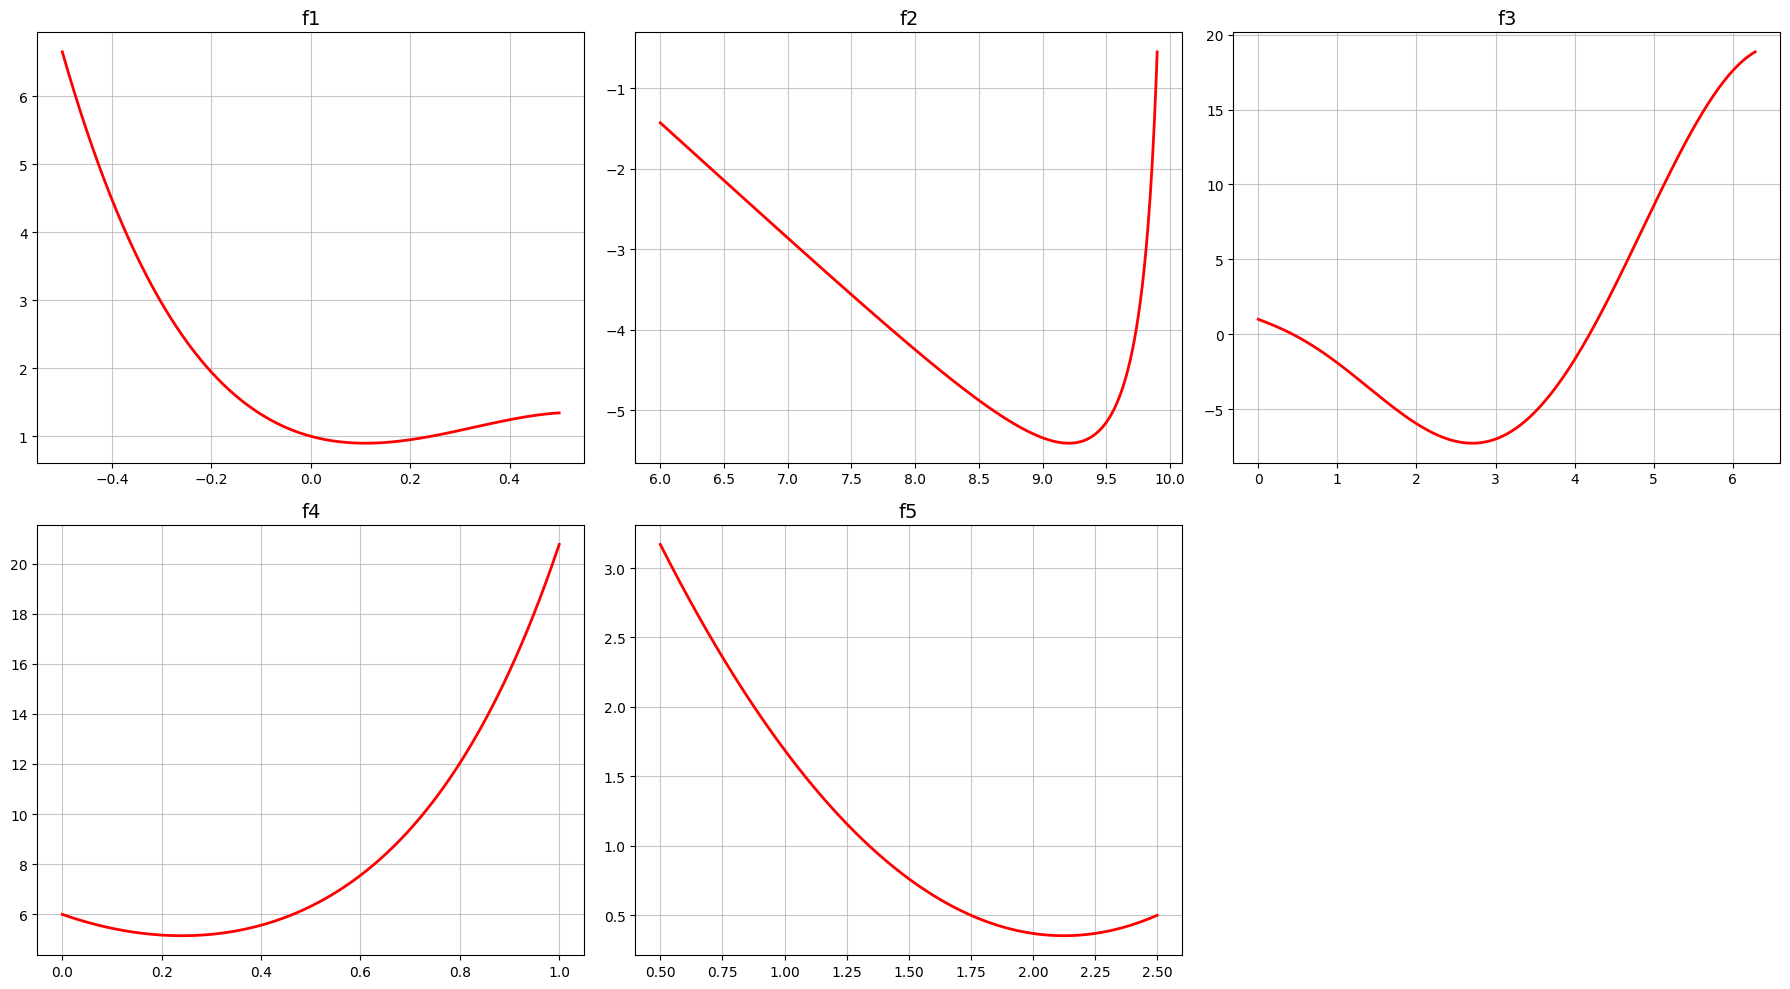

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i in range(5):
    x_array = np.linspace(intervals[i][0], intervals[i][1], 500)
    y = [functions[i](x) for x in x_array]
    axes[i // 3, i % 3].plot(x_array, y, color="red", linewidth=2)
    axes[i // 3, i % 3].set_title(f"f{i + 1}", fontsize=14)
    axes[i // 3, i % 3].grid(True, linestyle='-', alpha=0.7)

fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

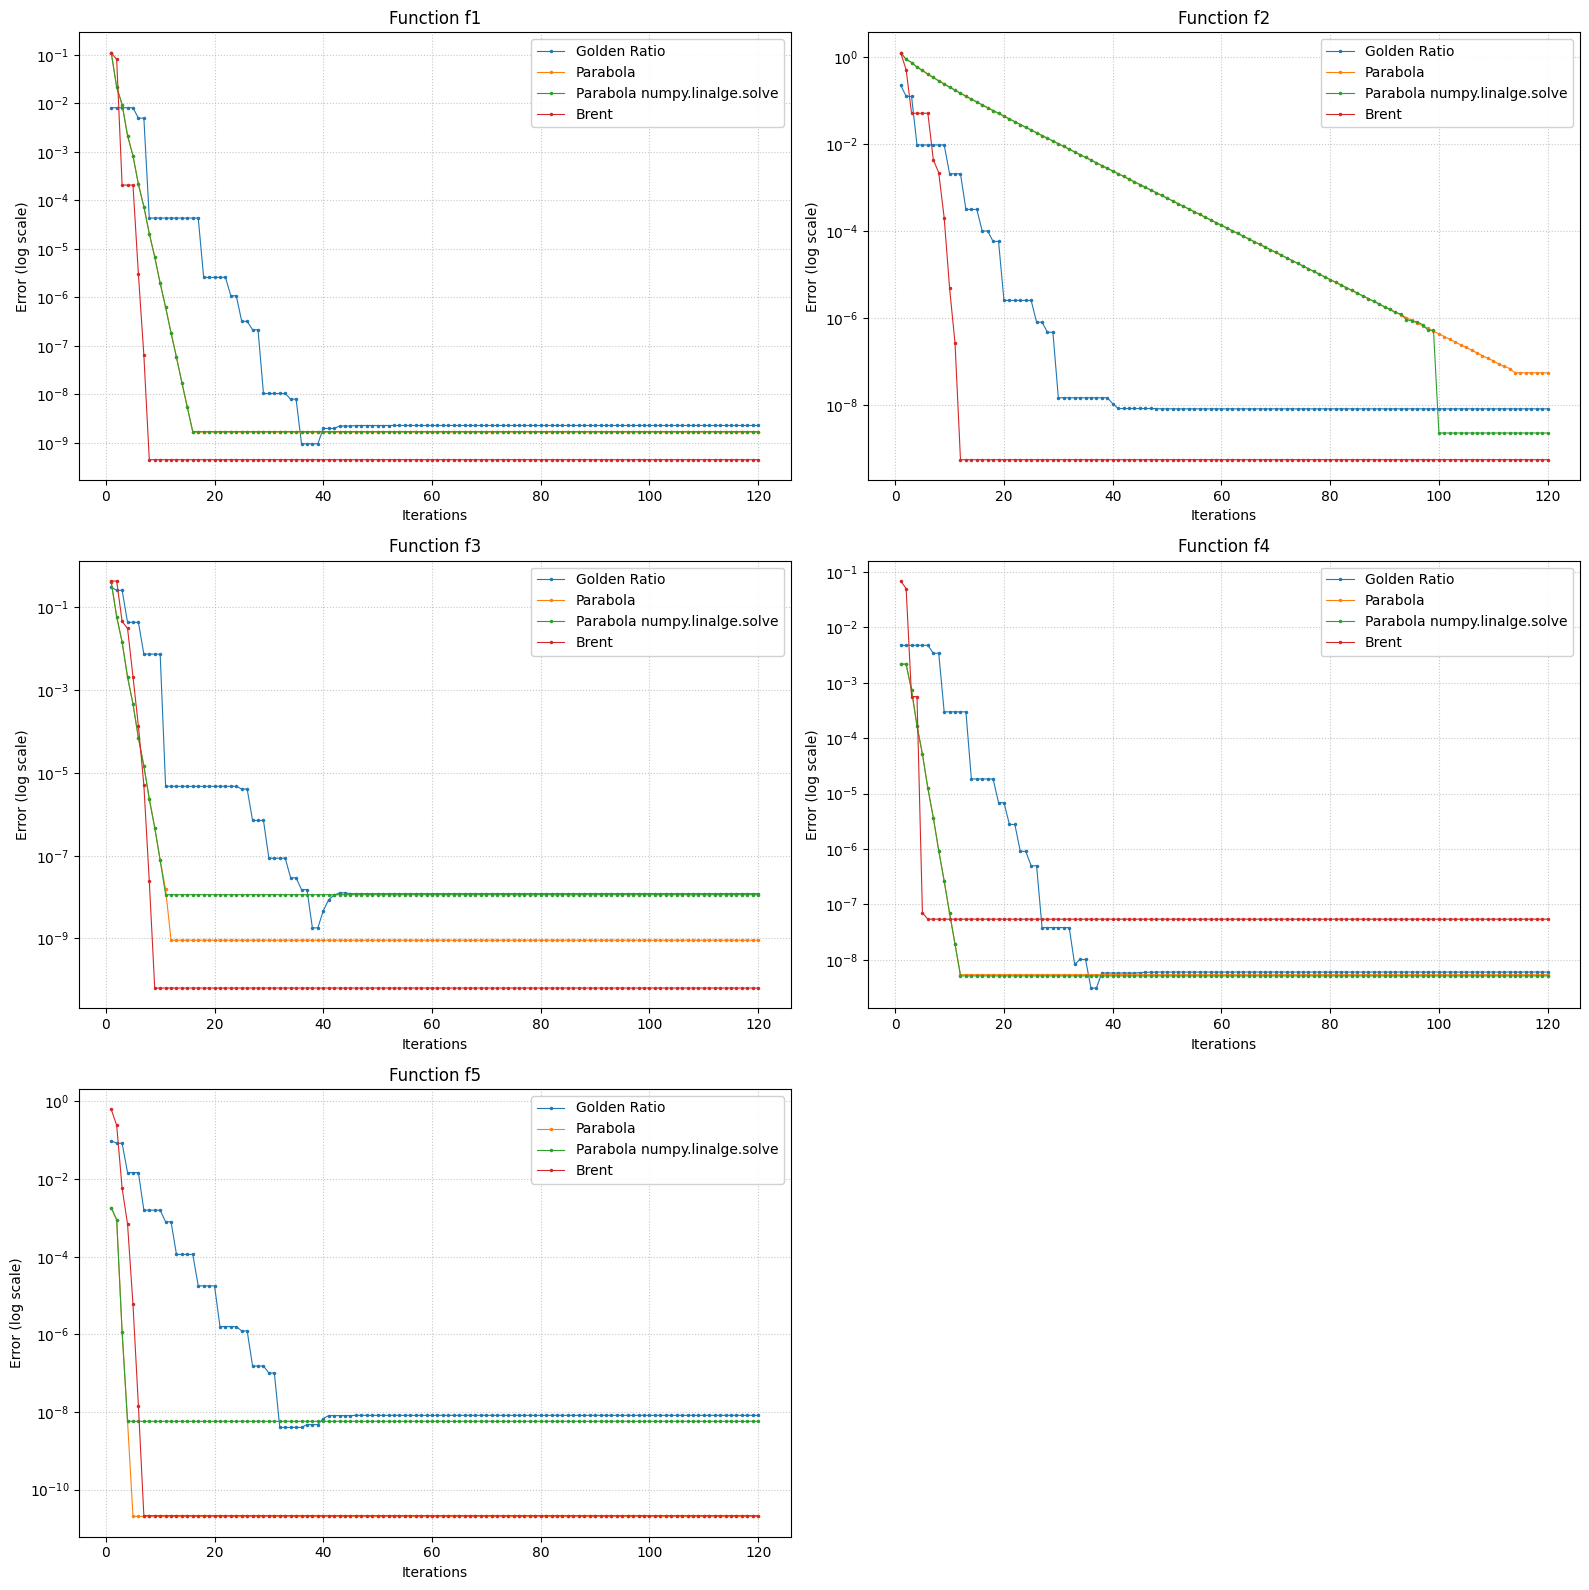

In [35]:
method_names = ["Golden Ratio", "Parabola", "Parabola numpy.linalge.solve", "Brent"]

fig, axes = plt.subplots(3, 2, figsize=(16, 16))
fig.subplots_adjust(hspace=0.5)

for i in range(5):
    ax = axes[i // 2, i % 2]
    ax.set_title(f'Function f{i+1}', fontsize=12)
    ax.set_xlabel('Iterations', fontsize=10)
    ax.set_ylabel('Error (log scale)', fontsize=10)
    ax.set_yticks(np.logspace(0,-10,10))
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    for method_idx in range(4):
        method_name = method_names[method_idx]
        if errors_all[i][method_idx]:
            ax.plot(x_space, errors_all[i][method_idx],
                   label=method_name,
                   markersize=3,
                   marker=".",
                   linewidth=0.8)
    ax.minorticks_off()
    ax.legend(fontsize=10, framealpha=0.9)

fig.delaxes(axes[2, 1])
plt.tight_layout()
plt.show()

Оценим скорости сходимостей

In [36]:
def estimate_convergence_order(errors):
    x = []
    y = []
    for i in range(1, len(errors)):
        x.append(np.log(abs(errors[i - 1])))
        y.append(np.log(abs(errors[i])))

    A = np.vstack([x, np.ones(len(x))]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]

    return a

def print_conv(errors_all, method_names, max_iter):
    for method_idx in range(len(method_names)):
        print(f"Оценка порядка сходимости для метода {method_names[method_idx]}:")
        for i in range(len(errors_all)):
            p = estimate_convergence_order(errors_all[i][method_idx][:max_iter])
            print(f"f{i+1}: ≈ {p:.3f}")
        print("-" * 50)

In [37]:
print_conv(errors_all, method_names, 20)

Оценка порядка сходимости для метода Golden Ratio:
f1: ≈ 0.918
f2: ≈ 1.010
f3: ≈ 0.903
f4: ≈ 0.975
f5: ≈ 0.938
--------------------------------------------------
Оценка порядка сходимости для метода Parabola:
f1: ≈ 0.943
f2: ≈ 0.965
f3: ≈ 0.905
f4: ≈ 0.922
f5: ≈ 0.740
--------------------------------------------------
Оценка порядка сходимости для метода Parabola numpy.linalge.solve:
f1: ≈ 0.943
f2: ≈ 0.965
f3: ≈ 0.885
f4: ≈ 0.923
f5: ≈ 0.660
--------------------------------------------------
Оценка порядка сходимости для метода Brent:
f1: ≈ 0.846
f2: ≈ 0.947
f3: ≈ 0.908
f4: ≈ 0.741
f5: ≈ 0.847
--------------------------------------------------


Из графиков и расчётов видно, что золотое сечение - самый стабильный, или же, предсказуемый метод. Парабола в основном имеет более быструю сходимость,но зависит от функции. Парабола с `numpy.linalge.solve` ведёт себя так же, но в некоторых функциях в результате отстает, либо, наоборот, при большом количестве итераций, добивается большей точности, по сравнению с явной формулой для параболы. Метод Брента является явным победителем по скорости на маленьком количестве итераций.
Скорости сходимости:
 - Метод золотого сечения - линейная
 - Метод парабол - суперлинейная
 - Метод парабол с `numpy.linalge.solve` - суперлинейная
 - Метод Брента - суперлинейная либо линейная, в зависимости от функции


#### Используем `scipy.optimize.minimize_scalar`:

In [38]:
errors_all_scipy = []
x_space_scipy = range(1, 61, 1)

for i, f in enumerate(functions):
    a, b = intervals[i]
    c = (a + b) / 2
    ref_x = reference_points[i]

    method_results = [
        [minimize_scalar(f, method='golden', bracket=(a, b), tol=1e-12, options={'maxiter': x}).x for x in x_space_scipy],
        [minimize_scalar(f, method='bounded', bounds=(a, b), options={'maxiter': x}).x for x in x_space_scipy],
        [minimize_scalar(f, method='brent', bracket=(a, b), tol=1e-12, options={'maxiter': x}).x for x in x_space_scipy]
    ]

    method_errors = [ [abs(x_k - ref_x) for x_k in method_results[j]] for j in range(3) ]
    errors_all_scipy.append(method_errors)


Построим графики:

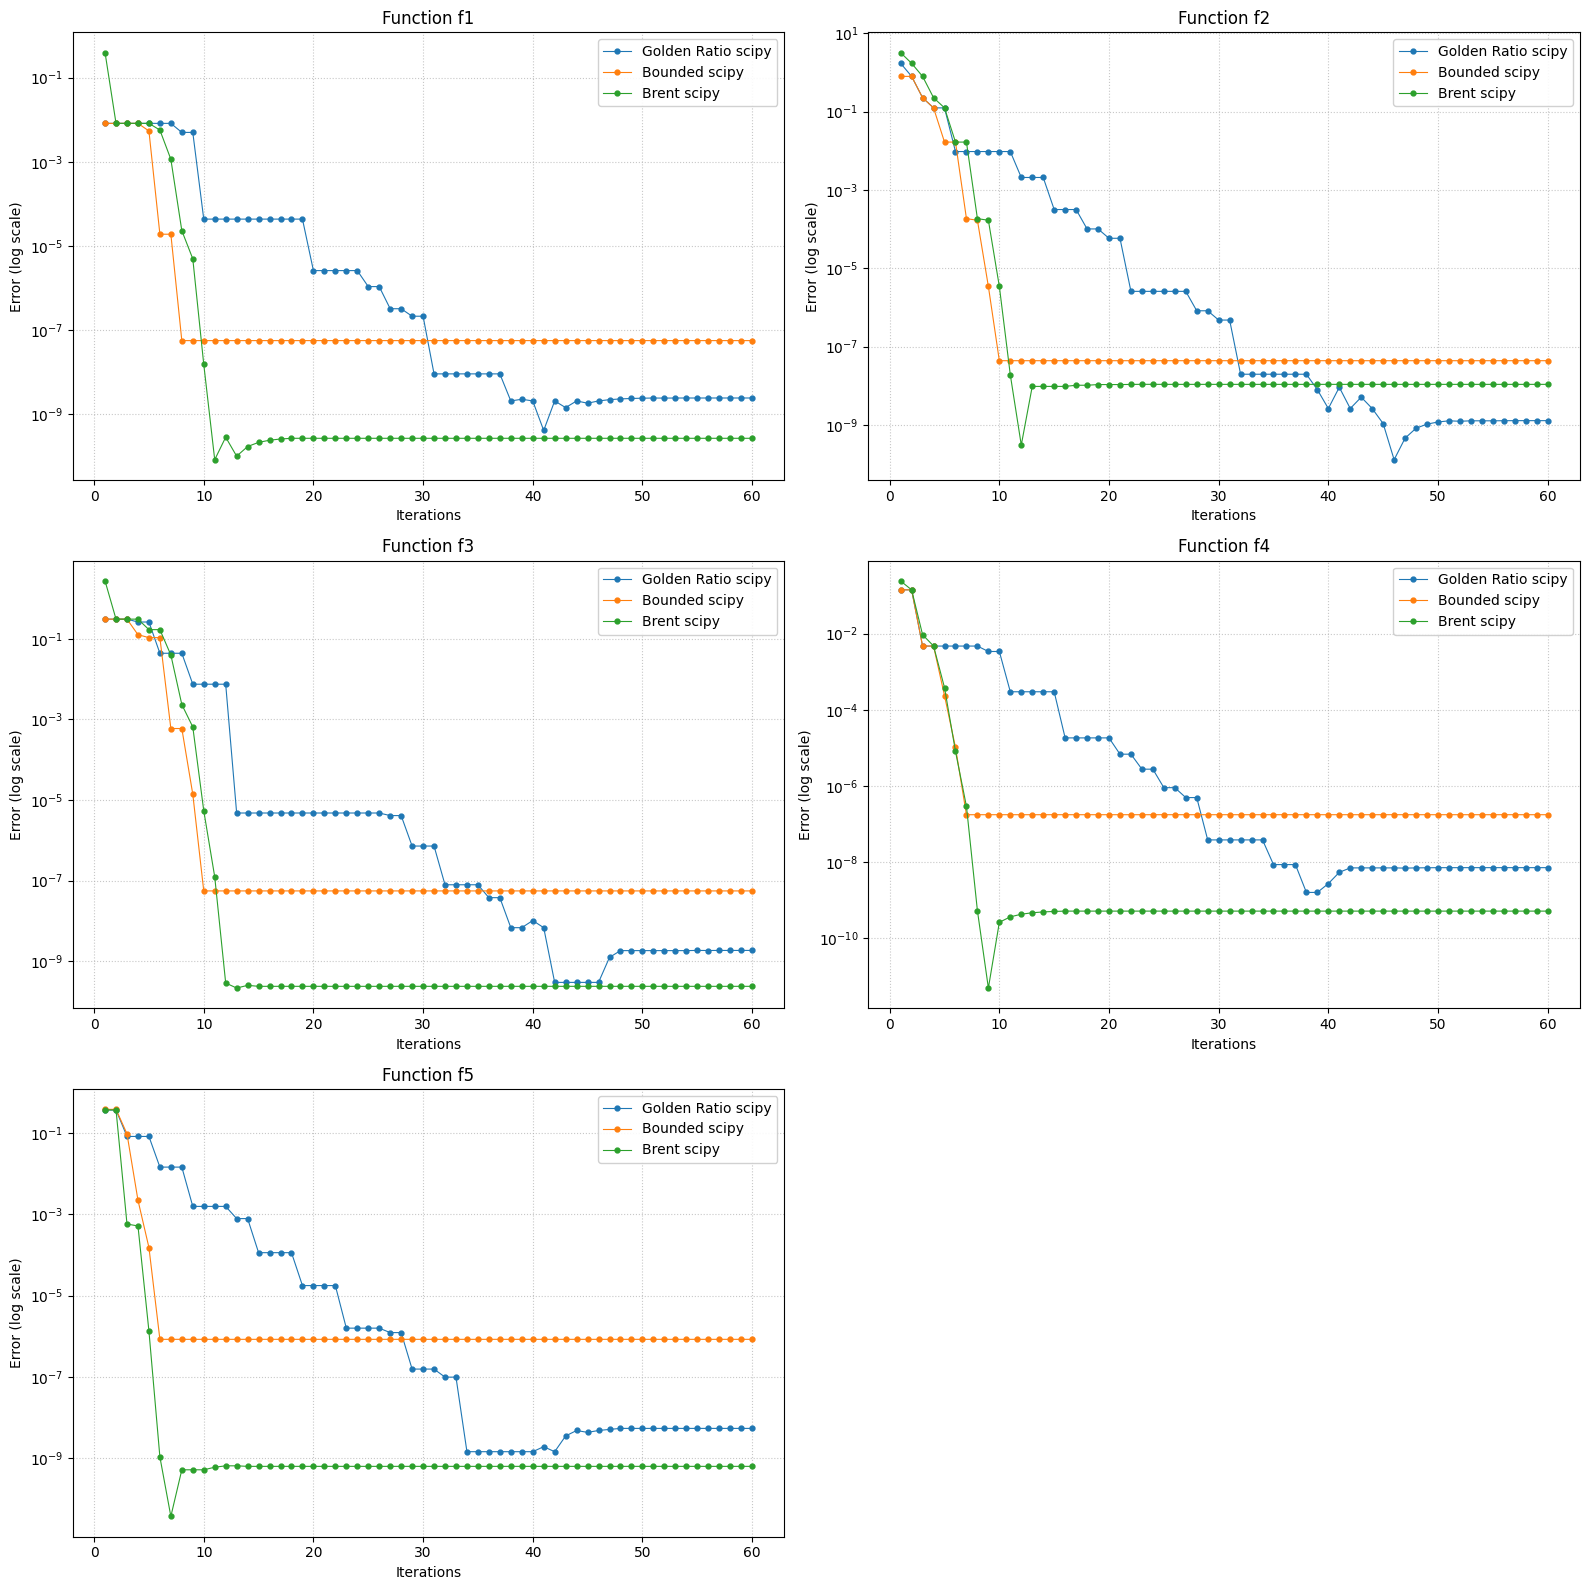

In [39]:
method_names_scipy = ["Golden Ratio scipy", "Bounded scipy", "Brent scipy"]

fig, axes = plt.subplots(3, 2, figsize=(16, 16))
fig.subplots_adjust(hspace=0.5)

for i in range(5):
    ax = axes[i // 2, i % 2]
    ax.set_title(f'Function f{i+1}', fontsize=12)
    ax.set_xlabel('Iterations', fontsize=10)
    ax.set_ylabel('Error (log scale)', fontsize=10)
    ax.set_yticks(np.logspace(0, -11, 10))
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    for method_idx in range(3):
        method_name = method_names_scipy[method_idx]
        if errors_all_scipy[i][method_idx]:
            ax.plot(x_space_scipy, errors_all_scipy[i][method_idx],
                   label=method_name,
                   markersize=7,
                   marker=".",
                   linewidth=0.8)
    ax.minorticks_off()
    ax.legend(fontsize=10, framealpha=0.9)

fig.delaxes(axes[2, 1])
plt.tight_layout()
plt.show()

Оценим скорости сходимостей

In [40]:
print_conv(errors_all_scipy, method_names_scipy, 40)

Оценка порядка сходимости для метода Golden Ratio scipy:
f1: ≈ 0.983
f2: ≈ 0.977
f3: ≈ 0.958
f4: ≈ 0.970
f5: ≈ 0.980
--------------------------------------------------
Оценка порядка сходимости для метода Bounded scipy:
f1: ≈ 0.871
f2: ≈ 0.897
f3: ≈ 0.909
f4: ≈ 0.829
f5: ≈ 0.813
--------------------------------------------------
Оценка порядка сходимости для метода Brent scipy:
f1: ≈ 0.896
f2: ≈ 0.903
f3: ≈ 0.927
f4: ≈ 0.852
f5: ≈ 0.786
--------------------------------------------------


В данном пакете нет метода параболы, в остальном, наблюдаем примерно такую же картину.

#### Теперь сравним наши методы с аналогичными из scipy

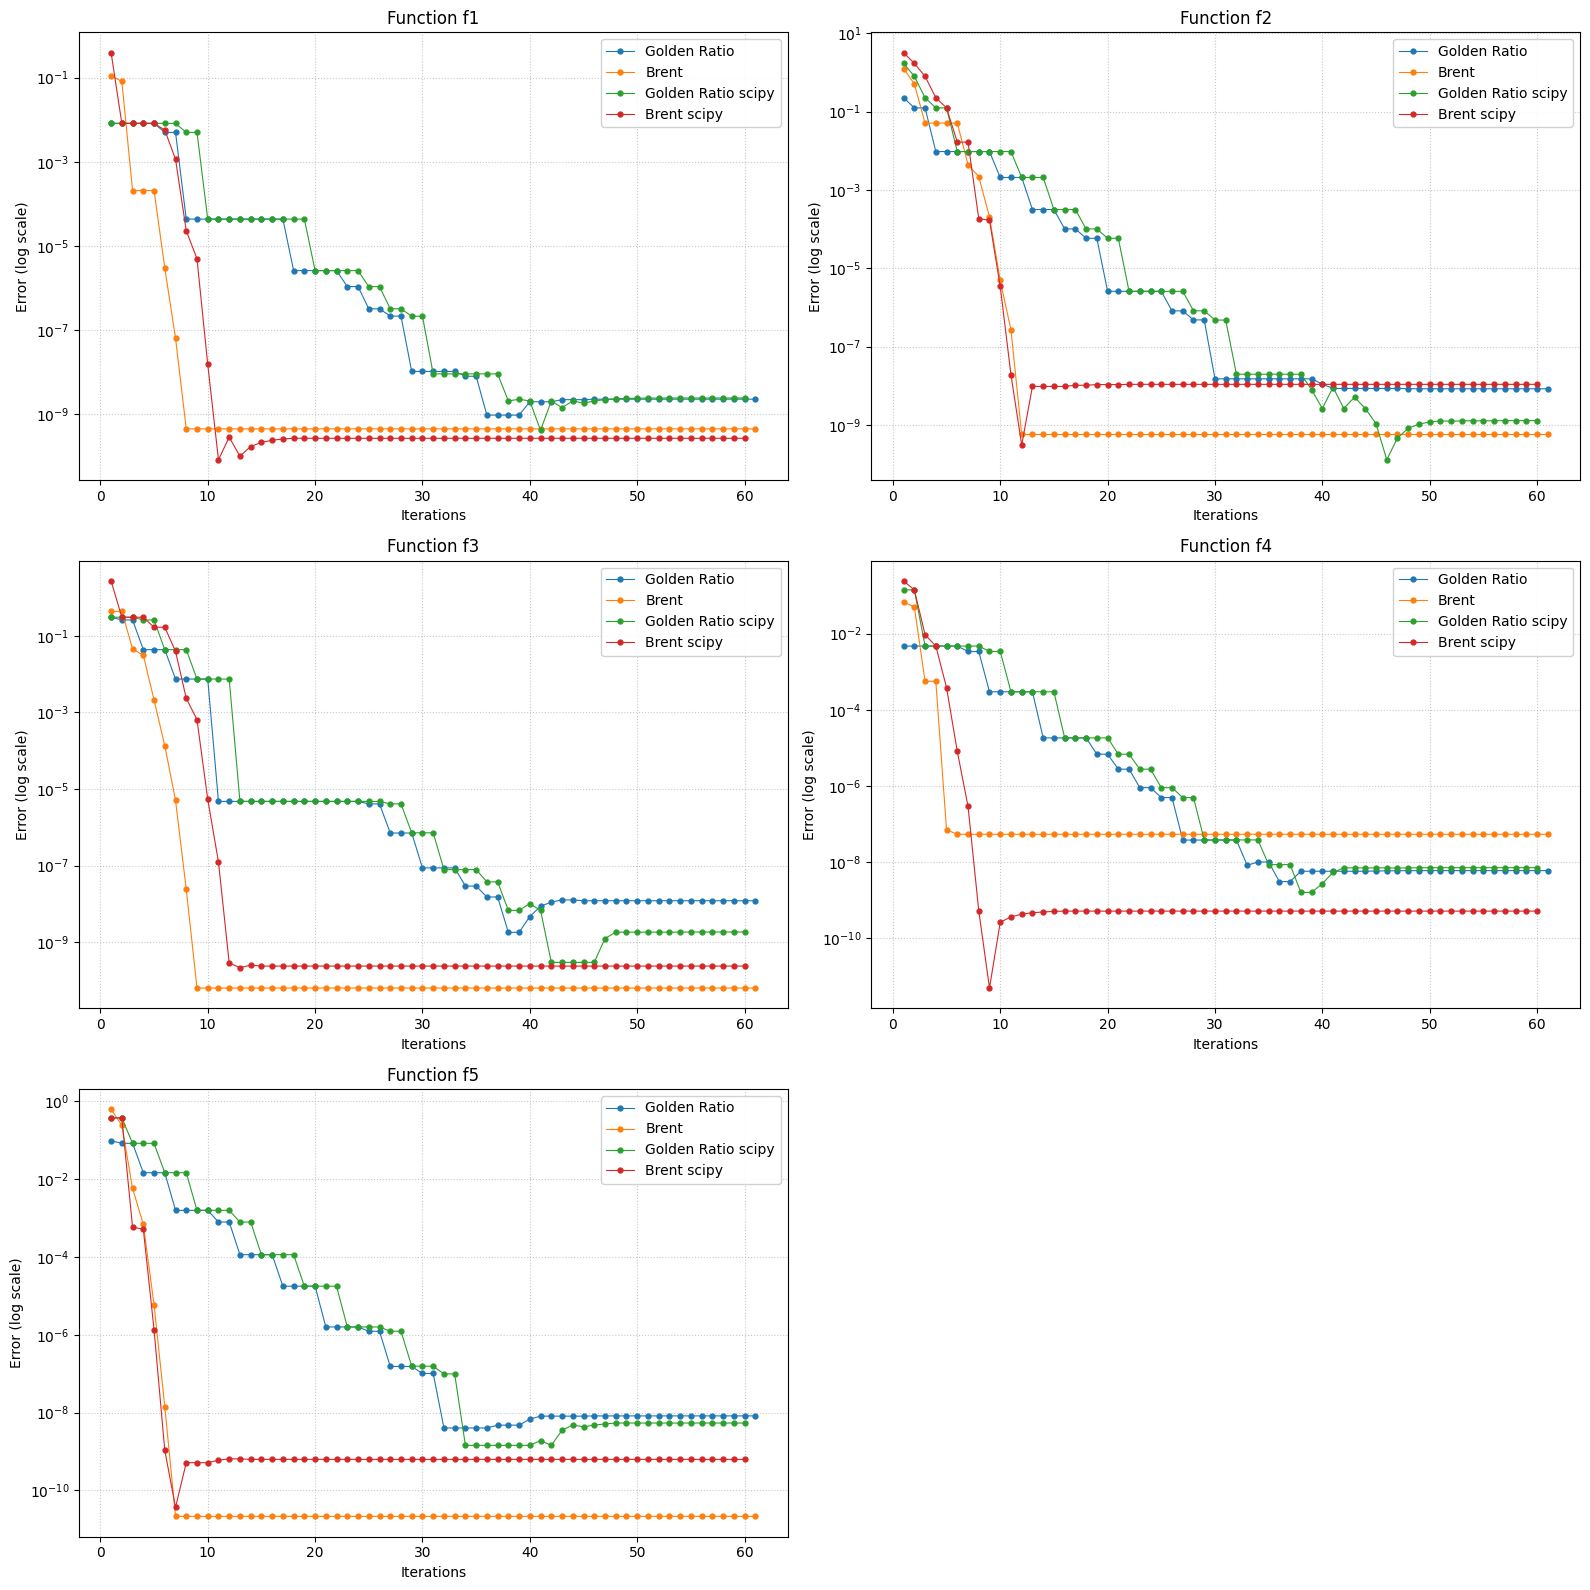

In [41]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
fig.subplots_adjust(hspace=0.5)

for i in range(5):
    ax = axes[i // 2, i % 2]
    ax.set_title(f'Function f{i+1}', fontsize=12)
    ax.set_xlabel('Iterations', fontsize=10)
    ax.set_ylabel('Error (log scale)', fontsize=10)
    ax.set_yticks(np.logspace(0,-10,10))
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle=':', alpha=0.7)

    for method_idx in (0, 3):
        method_name = method_names[method_idx]
        if errors_all[i][method_idx]:
            ax.plot(x_space[:61], errors_all[i][method_idx][:61],
                   label=method_name,
                   markersize=7,
                   marker=".",
                   linewidth=0.8)
    for method_idx in (0,2):
        method_name = method_names_scipy[method_idx]
        if errors_all_scipy[i][method_idx]:
            ax.plot(x_space[:60], errors_all_scipy[i][method_idx][:60],
                   label=method_name,
                   markersize=7,
                   marker=".",
                   linewidth=0.8)

    ax.minorticks_off()
    ax.legend(fontsize=10, framealpha=0.9)

fig.delaxes(axes[2, 1])
plt.tight_layout()
plt.show()

По графикам видно, что методы получились близки друг к другу, разве что, наш метод Брента подвисает на 4-й функции.
##### Теперь выберем 3 мультмодальные фунции и протестируем методы на них
Брать "хорошие" для анализа функции, может быть, и приятно, но полезнее и интереснее будет рассмотреть такие, на которых наши методы начнут ломаться. Поэтому возьмём функции: не сильно "выраженную" мултимодальную и с точкой минимума близкой к границе, сильно осцилирующую и с точкой минимума еще ближе к границе и средне-осцилирующую с точкой близко к центру.

In [42]:
def mm1(x):
    return (x-2)**2 * (x+1)**2 - x
def mm2(x):
    return np.exp(0.5*x) * np.sin(4*x)
def mm3(x):
    return -np.cos(4*x - 0.2)*np.cos(6*x - 0.2)

mm_functions = [mm1, mm2, mm3]
mm_intervals = [
    [-1.1, 2.5],
    [-1, 6],
    [-0.8, 0.8]
]

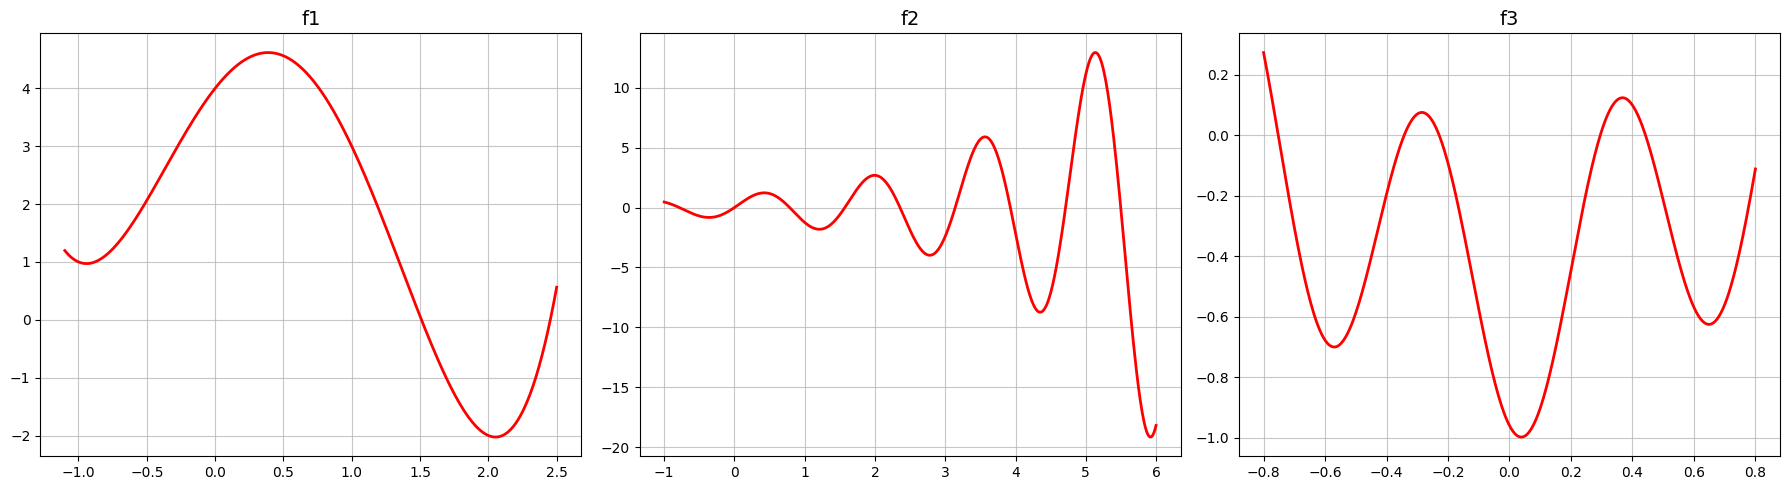

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    x_array = np.linspace(mm_intervals[i][0], mm_intervals[i][1], 500)
    y = [mm_functions[i](x) for x in x_array]
    axes[i].plot(x_array, y, color="red", linewidth=2)
    axes[i].set_title(f"f{i + 1}", fontsize=14)
    axes[i].grid(True, linestyle='-', alpha=0.7)

plt.tight_layout()
plt.show()

Получение эталонных значений $x$, при которых функция на заданном отрезке минимальна

In [44]:
mm_intervals_for_dd = [
    [0.5, 2.5],
    [5, 7],
    [-0.22, 0.24]
]
derivatives_mm = [
    lambda x: 4*x**3 - 6*x**2 - 6*x + 3,
    lambda x: np.exp(0.5*x)*(np.sin(4*x)*0.5 + 4*np.cos(4*x)),
    lambda x: 4*(np.sin(4*x - 0.2)*np.cos(6*x - 0.2) + 1.5*np.sin(6*x - 0.2)*np.cos(4*x - 0.2))
]
reference_points_mm = []

for i, f in enumerate(derivatives_mm):
    reference_points_mm.append(round(bisect(f, a=mm_intervals_for_dd[i][0], b=mm_intervals_for_dd[i][1]), 12))
    print(f"f{i+1}: {reference_points_mm[i]}")

f1: 2.052741308262
f2: 6.706973137514
f3: 0.038462938859


In [45]:
errors_all_mm = []
x_space_mm = range(1, 61, 1)

for i, f in enumerate(mm_functions):
    a, b = mm_intervals[i]
    c = b - 0.01
    ref_x = reference_points_mm[i]

    method_results = [
        [golden_ratio_method(f, a, b, max_iter=x, epsilon=1e-12)[0] for x in x_space_mm],
        [parabola_method(f, a, c, b, max_iter=x, epsilon=1e-12)[0] for x in x_space_mm],
        [parabola_method_numpy(f, a, c, b, max_iter=x, epsilon=1e-12)[0] for x in x_space_mm],
        [brent_method(f, a, b, max_iter=x, epsilon=1e-12)[0] for x in x_space_mm]
    ]

    method_errors = [ [abs(x_k - ref_x) for x_k in method_results[j]] for j in range(4) ]
    errors_all_mm.append(method_errors)


Построим графики

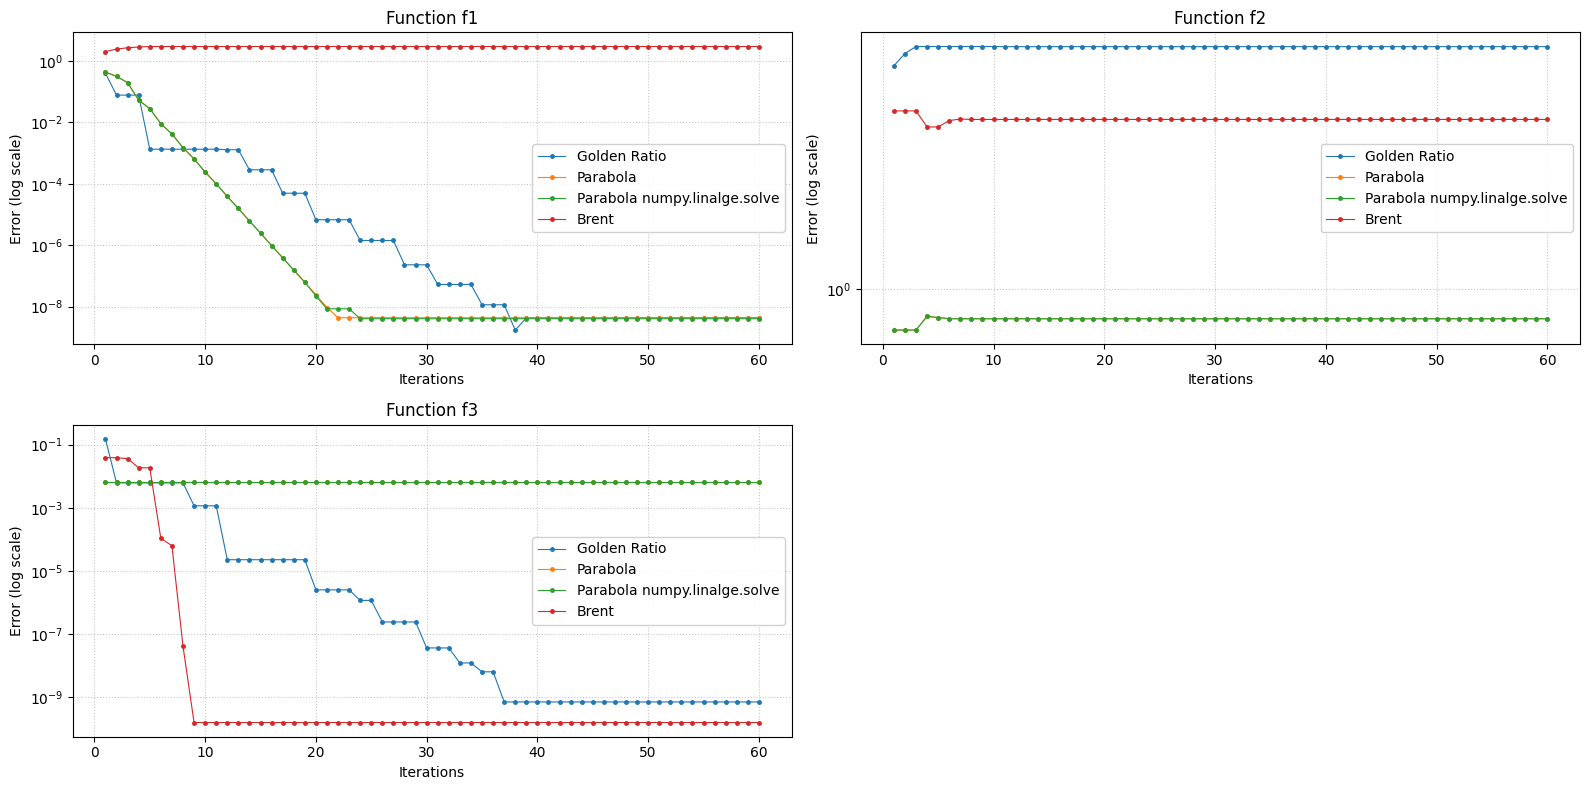

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)

for i in range(3):
    ax = axes[i // 2, i % 2]
    ax.set_title(f'Function f{i+1}', fontsize=12)
    ax.set_xlabel('Iterations', fontsize=10)
    ax.set_ylabel('Error (log scale)', fontsize=10)
    ax.set_yticks(np.logspace(0,-10,10))
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    for method_idx in range(4):
        method_name = method_names[method_idx]
        if errors_all_mm[i][method_idx]:
            ax.plot(x_space_mm, errors_all_mm[i][method_idx],
                   label=method_name,
                   markersize=5,
                   marker=".",
                   linewidth=0.8)
    ax.minorticks_off()
    ax.legend(fontsize=10, framealpha=0.9)

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

Оценим скорости сходимостей

In [47]:
print_conv(errors_all_mm, method_names, 40)

Оценка порядка сходимости для метода Golden Ratio:
f1: ≈ 0.962
f2: ≈ 0.320
f3: ≈ 0.967
--------------------------------------------------
Оценка порядка сходимости для метода Parabola:
f1: ≈ 0.951
f2: ≈ 0.590
f3: ≈ 0.962
--------------------------------------------------
Оценка порядка сходимости для метода Parabola numpy.linalge.solve:
f1: ≈ 0.951
f2: ≈ 0.590
f3: ≈ 0.962
--------------------------------------------------
Оценка порядка сходимости для метода Brent:
f1: ≈ 0.495
f2: ≈ 0.441
f3: ≈ 0.899
--------------------------------------------------


Самое примечательно - с осциляцией не справился никто ($f_2$). Это произошло, потому что на первых итерациях алгоритмы не могут найти хорошую точку, так как постоянно перескакивают с одной "горки" фукнции на другую. Первую функцию смогли побороть метод золотого сечения и методы парабол, метод Брента запутался и выбрал неверную стратегию на первых же ходах, из-за чего ушёл совсем мимо. В третьей функции, напротив, метод Брента вместе с золотым сечением смог найти хорошее приближение (учитывая то, как работает алгоритм - верная стратегия тут, по всей видимости, оказалась выбирать золотое сечение при первом приближении, и после нескольких шагов переключиться на параболу и эффективно "добить" цель в пару итераций).

# **Градентный спуск**

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from time import time
from mpl_toolkits.mplot3d import Axes3D

In [49]:
#Градиентный спуск

def gradient_descent(f, grad_f, x0, alpha_strategy, max_iter=1000, tol=1e-6, **kwargs):
    x = x0.copy()
    trajectory = [x0.copy()]
    for k in range(max_iter):
        grad = grad_f(x)
        if np.linalg.norm(grad) < tol:
            break

        alpha = alpha_strategy(f, grad_f, x, grad, **kwargs)
        x = x - alpha * grad
        trajectory.append(x.copy())

    return np.array(trajectory), k

# Стратегии выбора шага
def constant_alpha(f, grad_f, x, grad, alpha=0.1, **kwargs):
    return alpha

def exact_line_search(f, grad_f, x, grad, **kwargs):
    from scipy.optimize import minimize_scalar
    def phi(beta):
        return f(x - beta * grad / np.linalg.norm(grad))
    res = minimize_scalar(phi, bounds=(0, 10), method='bounded')
    return res.x / np.linalg.norm(grad)

def adaptive_lipschitz(f, grad_f, x, grad, L0=1.0, eta=1.1, **kwargs):
    L = L0
    while True:
        alpha = 1 / L
        x_new = x - alpha * grad
        if f(x_new) <= f(x) - 0.5 * alpha * np.linalg.norm(grad)**2:
            return alpha
        L *= eta

def armijo_wolfe(f, grad_f, x, grad, alpha0=1.0, c1=1e-4, c2=0.9, rho=0.5, **kwargs):
    alpha = alpha0
    while True:
        x_new = x - alpha * grad
        # Условие Армихо
        if f(x_new) > f(x) - c1 * alpha * np.linalg.norm(grad)**2:
            alpha *= rho
            continue
        # Условие Вульфа (опционально)
        grad_new = grad_f(x_new)
        if np.dot(grad_new, grad) < c2 * np.linalg.norm(grad)**2:
            alpha *= 1.1
            continue
        break
    return alpha

Теоретическая скорость сходимости: 0.641


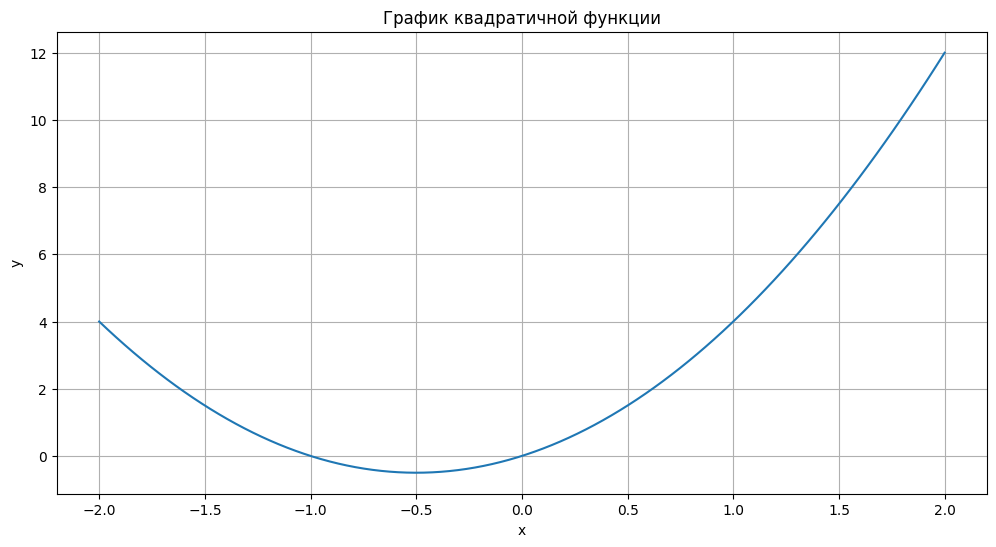

Constant α=1/L: 34 итераций, время: 0.00 сек
Exact line search: 999 итераций, время: 6.17 сек
Adaptive Lipschitz: 19 итераций, время: 0.00 сек


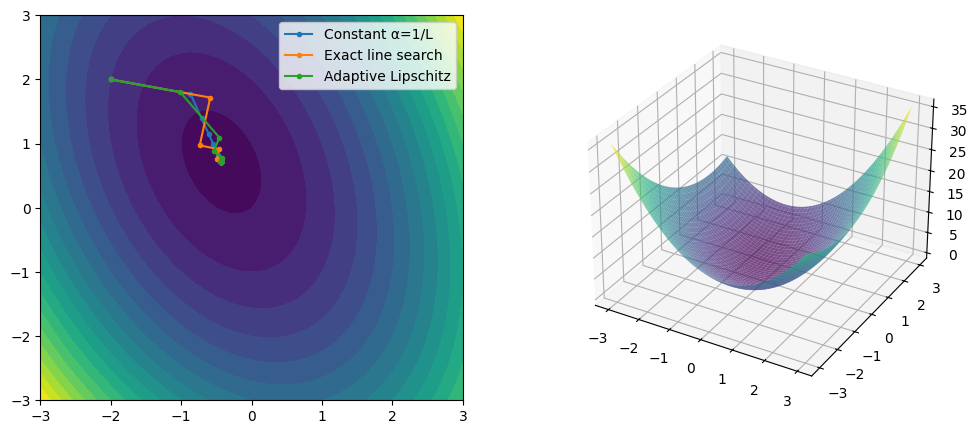

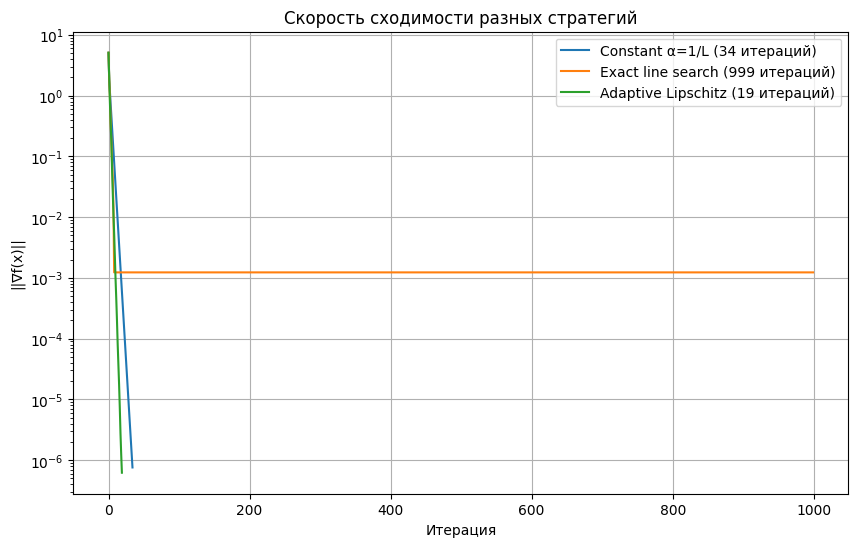

In [50]:


# Оптимизированные стратегии градиентного спуска
def gradient_descent(f, grad_f, x0, alpha_strategy, max_iter=1000, tol=1e-6, **kwargs):
    x = x0.copy()
    trajectory = [x0.copy()]
    grad_norms = []

    for k in range(max_iter):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        grad_norms.append(grad_norm)
        if grad_norm < tol:
            break

        alpha = alpha_strategy(f, grad_f, x, grad, **kwargs)
        x = x - alpha * grad
        trajectory.append(x.copy())

    return np.array(trajectory), k, grad_norms

# Ускоренные стратегии выбора шага
def constant_alpha(**kwargs):
    return kwargs.get('alpha', 0.1)

def exact_line_search(f, grad_f, x, grad, max_beta=10):
    """Векторизованный точный поиск с ограничением диапазона"""
    beta_values = np.linspace(0, max_beta, 1000)
    f_values = np.array([f(x - b * grad / np.linalg.norm(grad)) for b in beta_values])
    return beta_values[np.argmin(f_values)] / np.linalg.norm(grad)

def adaptive_lipschitz(f, grad_f, x, grad, L0=1.0, eta=1.5, max_backtrack=20):
    """Адаптивный поиск с экспоненциальным ростом L"""
    L = L0
    for _ in range(max_backtrack):
        alpha = 1 / L
        x_new = x - alpha * grad
        if f(x_new) <= f(x) - 0.5 * alpha * np.linalg.norm(grad)**2:
            return alpha
        L *= eta
    return 1 / L

#Оптимизированная квадратичная функция
A = np.array([[2, 0.5], [0.5, 1]])
b = np.array([1, -1])
quadratic_f = lambda x: x.T @ A @ x + b.T @ x
quadratic_grad = lambda x: 2 * A @ x + b

# Аналитические константы
L = 2 * np.max(np.linalg.eigvals(A))
mu = 2 * np.min(np.linalg.eigvals(A))
print(f"Теоретическая скорость сходимости: {1 - mu/L:.3f}")


#Графиик квадратичной функциии
plt.figure(figsize=(12,6))
xs = np.linspace(-2, 2, 100)
ys = [quadratic_f(np.array([x, -x])) for x in xs]
plt.xlabel('x')
plt.ylabel('y')
plt.title('График квадратичной функции')
plt.grid(True)
plt.plot(xs, ys)
plt.show()






# Ускоренная визуализация (векторизованная)
def plot_optimization(f, x_range=(-3,3), y_range=(-3,3), trajectories=None):
    x = np.linspace(*x_range, 100)
    y = np.linspace(*y_range, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    # Векторизованный расчет Z
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = f(np.array([X[i,j], Y[i,j]]))

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.contourf(X, Y, Z, levels=20, cmap='viridis')

    if trajectories:
        for name, traj in trajectories.items():
            plt.plot(traj[:,0], traj[:,1], 'o-', markersize=3, label=name)
        plt.legend()

    plt.subplot(1,2,2, projection='3d')
    plt.gca().plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
    plt.show()

# Сравнение стратегий с таймингом
x0 = np.array([-2., 2.])
strategies = {
    "Constant α=1/L": lambda *args: constant_alpha(alpha=1/L),
    "Exact line search": exact_line_search,
    "Adaptive Lipschitz": adaptive_lipschitz
}

results = {}
for name, strategy in strategies.items():
    start_time = time()
    traj, iters, grad_norms = gradient_descent(quadratic_f, quadratic_grad, x0, strategy)
    results[name] = {
        'trajectory': traj,
        'iterations': iters,
        'time': time() - start_time,
        'grad_norms': grad_norms}
    print(f"{name}: {iters} итераций, время: {results[name]['time']:.2f} сек")

plot_optimization(quadratic_f, trajectories={k: v['trajectory'] for k,v in results.items()})

# Графики скорости сходимости
plt.figure(figsize=(10,6))
for name, data in results.items():
    plt.semilogy(data['grad_norms'], label=f"{name} ({data['iterations']} итераций)")
plt.xlabel('Итерация')
plt.ylabel('||∇f(x)||')
plt.legend()
plt.title('Скорость сходимости разных стратегий')
plt.grid()
plt.show()

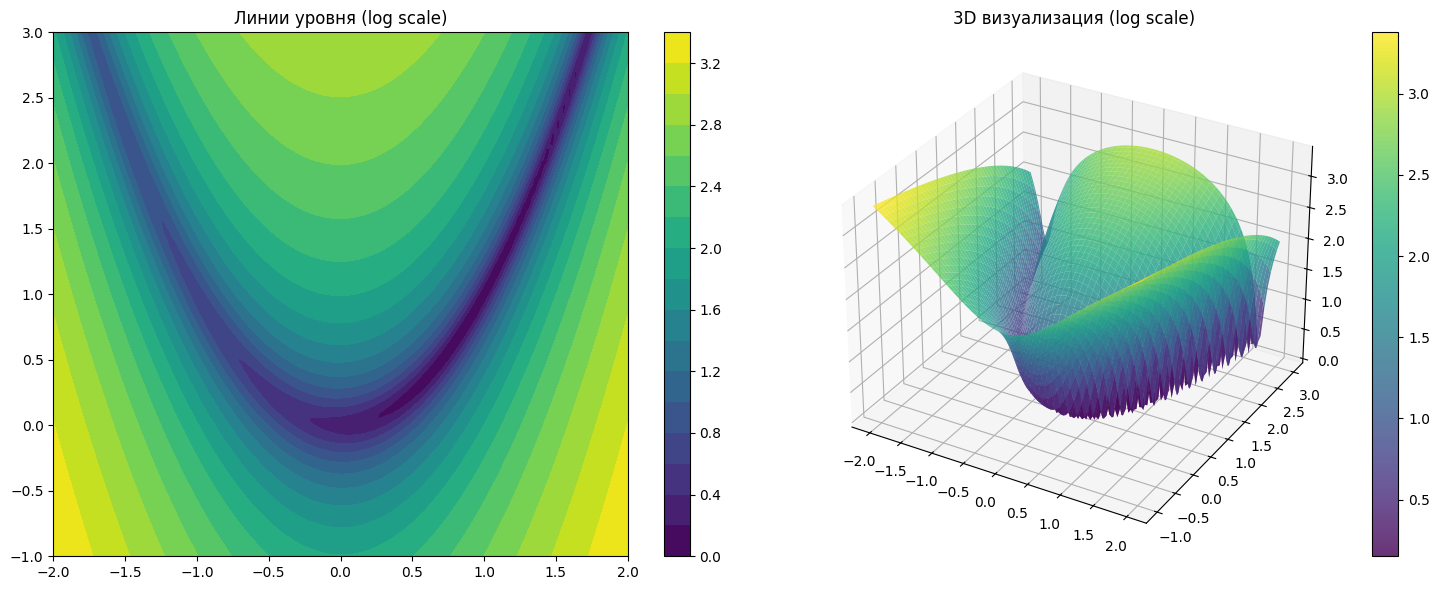

Constant α=0.001: 9999 итераций, конечная точка: [0.99166048 0.98335696]
Exact line search: 9999 итераций, конечная точка: [0.99999867 0.99999733]
Adaptive Lipschitz: 993 итераций, конечная точка: [0.99999894 0.99999788]


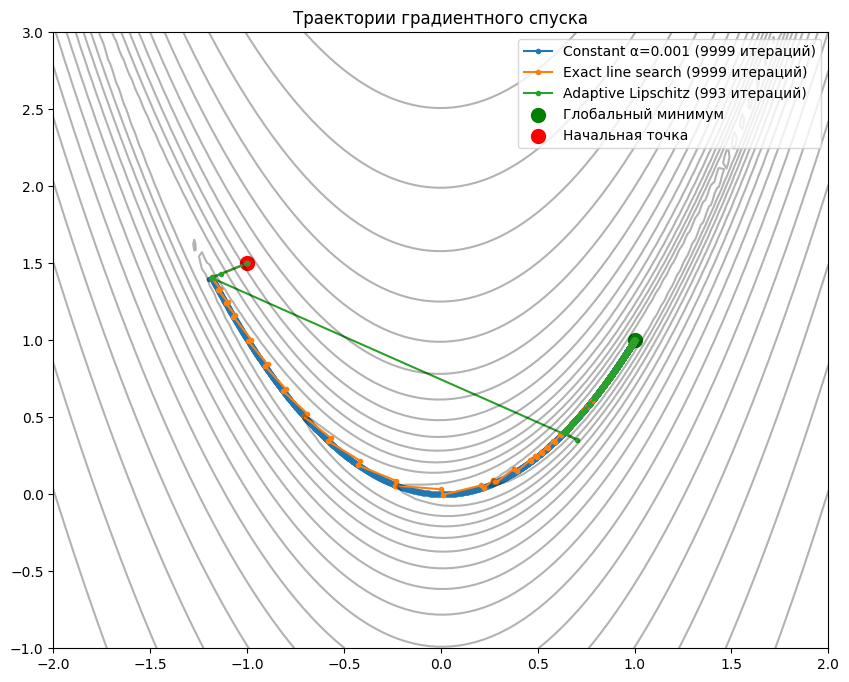

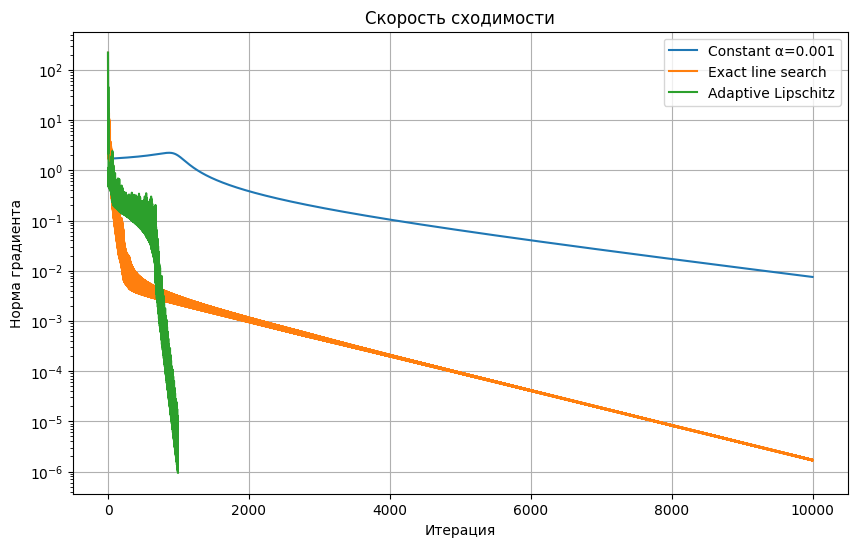

In [51]:
# Оптимизированная функция Розенброка
def rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

# Градиент с защитой от переполнения
def rosenbrock_grad(x):
    x_sq = x[0]**2
    y_minus_xsq = x[1] - x_sq
    return np.array([
        -2*(1 - x[0]) - 400*x[0]*y_minus_xsq,
        200*y_minus_xsq
    ])

# Векторизованная визуализация
def plot_rosenbrock():
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-1, 3, 100)
    X, Y = np.meshgrid(x, y)

    # Векторизованное вычисление Z
    Z = (1 - X)**2 + 100*(Y - X**2)**2

    fig = plt.figure(figsize=(15, 6))

    # 2D график
    ax1 = fig.add_subplot(121)
    contour = ax1.contourf(X, Y, np.log10(Z+1), levels=20, cmap='viridis')
    fig.colorbar(contour, ax=ax1)
    ax1.set_title("Линии уровня (log scale)")

    # 3D график
    ax2 = fig.add_subplot(122, projection='3d')
    surf = ax2.plot_surface(X, Y, np.log10(Z+1), cmap='viridis', alpha=0.8)
    fig.colorbar(surf, ax=ax2)
    ax2.set_title("3D визуализация (log scale)")

    plt.tight_layout()
    plt.show()

plot_rosenbrock()

# Модифицированный градиентный спуск
def gradient_descent(f, grad_f, x0, strategy, max_iter=10000, tol=1e-6):
    x = x0.copy()
    trajectory = [x0.copy()]
    grad_norms = []

    for k in range(max_iter):
        try:
            grad = grad_f(x)
            grad_norm = np.linalg.norm(grad)
            grad_norms.append(grad_norm)

            if grad_norm < tol or np.isnan(grad_norm):
                break

            alpha = strategy(f, grad_f, x, grad)
            x = x - alpha * grad
            trajectory.append(x.copy())
        except:
            break

    return np.array(trajectory), k, grad_norms

# Стратегии с защитой от расходимости
strategies = {
    "Constant α=0.001": lambda *args: 0.001,
    "Exact line search": lambda f, grad_f, x, grad: minimize_scalar(
        lambda a: f(x - a*grad), bounds=(0, 0.1)).x,
    "Adaptive Lipschitz": lambda f, grad_f, x, grad, L0=1.0, eta=1.5: (
        L := L0,
        [L := L*eta for _ in range(20)
            if f(x - grad/L) > f(x) - 0.5*np.linalg.norm(grad)**2/L],
        1/L
    )[-1]
}

# Запуск оптимизации
x0 = np.array([-1.0, 1.5])
plt.figure(figsize=(10, 8))

for name, strategy in strategies.items():
    traj, iters, norms = gradient_descent(rosenbrock, rosenbrock_grad, x0, strategy)

    if len(traj) > 0:
        plt.plot(traj[:,0], traj[:,1], 'o-', markersize=3,
                label=f"{name} ({iters} итераций)")
        print(f"{name}: {iters} итераций, конечная точка: {traj[-1]}")
    else:
        print(f"{name}: метод расходится")

# Визуализация результатов
X, Y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-1, 3, 100))
Z = (1 - X)**2 + 100*(Y - X**2)**2

plt.contour(X, Y, np.log10(Z+1), levels=20, colors='k', alpha=0.3)
plt.scatter(1, 1, c='g', s=100, label="Глобальный минимум")
plt.scatter(x0[0], x0[1], c='r', s=100, label="Начальная точка")
plt.legend()
plt.title("Траектории градиентного спуска")
plt.show()

# График сходимости
plt.figure(figsize=(10, 6))
for name, strategy in strategies.items():
    traj, iters, norms = gradient_descent(rosenbrock, rosenbrock_grad, x0, strategy)
    if len(norms) > 0:
        plt.semilogy(norms, label=name)
plt.xlabel('Итерация')
plt.ylabel('Норма градиента')
plt.legend()
plt.title('Скорость сходимости')
plt.grid()
plt.show()

Для гладких выпуклых функций (квадратичная):

Точный линейный поиск сходится быстрее всего.

Постоянный шаг α = 1/L дает предсказуемую линейную сходимость.

Для невыпуклых функций (Розенброк):

Градиентный спуск работает плохо из-за овражного ландшафта.

Требуются более сложные методы (Ньютона, адаптивные).

Выбор стратегии зависит от функции:

Если функция гладкая и выпуклая, тогда используем точный поиск.

Если функция сложная (невыпуклая, овражная), тогда используем адаптивные методы (Армихо–Вульф)




# **Построение траектории**

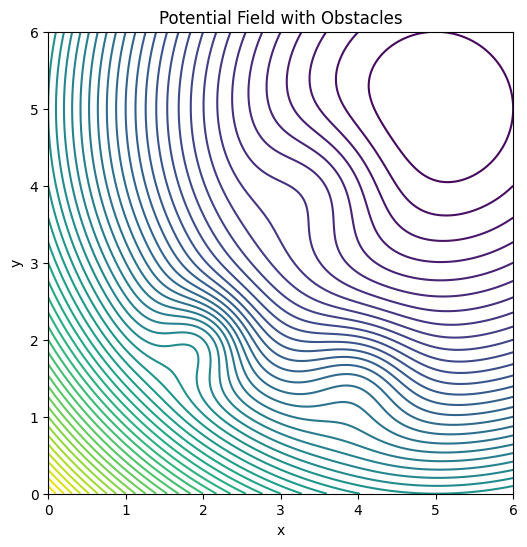

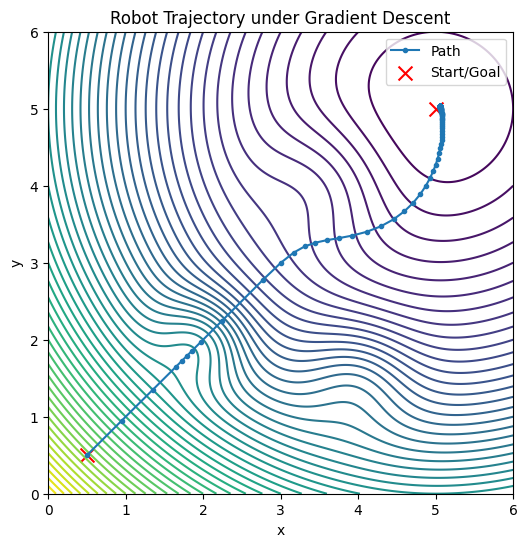

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры задачи
xB, yB = 5.0, 5.0        # координаты цели B
a = 1.0                  # вес квадратичного терма к цели

# Задаём препятствия в виде гауссовых «холмов»
obstacles = [
    {'xp': 2.0, 'yp': 2.0, 'b': 5.0, 'sigmax': 0.4, 'sigmay': 0.4},
    {'xp': 3.5, 'yp': 4.0, 'b': 3.0, 'sigmax': 0.6, 'sigmay': 0.6},
    {'xp': 4.0, 'yp': 1.5, 'b': 4.0, 'sigmax': 0.5, 'sigmay': 0.5}
]

# Потенциальная функция F(x, y)
def F_xy(x, y):
    # вклад цели
    pot = a * ((x - xB)**2 + (y - yB)**2)
    # вклад препятствий
    for obs in obstacles:
        pot += obs['b'] * np.exp(
            -((x - obs['xp'])**2) / (2 * obs['sigmax']**2)
            -((y - obs['yp'])**2) / (2 * obs['sigmay']**2)
        )
    return pot

# Градиент потенциальной функции
def gradF(X):
    x, y = X
    # градиент квадратичного терма
    dx = 2 * a * (x - xB)
    dy = 2 * a * (y - yB)
    # градиент гауссовых термов
    for obs in obstacles:
        exp_term = np.exp(
            -((x - obs['xp'])**2) / (2 * obs['sigmax']**2)
            -((y - obs['yp'])**2) / (2 * obs['sigmay']**2)
        )
        dx += obs['b'] * exp_term * (-(x - obs['xp']) / obs['sigmax']**2)
        dy += obs['b'] * exp_term * (-(y - obs['yp']) / obs['sigmay']**2)
    return np.array([dx, dy])

# Параметры градиентного спуска
start = np.array([0.5, 0.5])   # начальная точка A
alpha = 0.05                   # шаг
tol = 1e-3                     # критерий остановки по норме градиента
max_iter = 1000               # максимальное число итераций

# Считаем траекторию
Xk = start.copy()
trajectory = [Xk.copy()]
for i in range(max_iter):
    g = gradF(Xk)
    Xk = Xk - alpha * g
    trajectory.append(Xk.copy())
    if np.linalg.norm(g) < tol:
        break
trajectory = np.array(trajectory)

# Визуализация
# 1) контурное поле
xx = np.linspace(0, 6, 300)
yy = np.linspace(0, 6, 300)
X, Y = np.meshgrid(xx, yy)
Z = F_xy(X, Y)

plt.figure(figsize=(6,6))
plt.contour(X, Y, Z, levels=60)
plt.title("Potential Field with Obstacles")
plt.xlabel("x")
plt.ylabel("y")

# 2) траектория поверх контуров
plt.figure(figsize=(6,6))
plt.contour(X, Y, Z, levels=60)
plt.plot(trajectory[:,0], trajectory[:,1], '-o', markersize=3, label="Path")
plt.scatter([start[0], xB], [start[1], yB], c='r', marker='x', s=100, label="Start/Goal")
plt.title("Robot Trajectory under Gradient Descent")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()
